# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

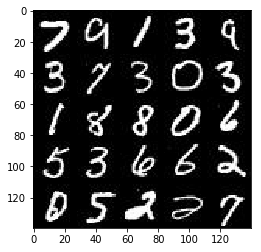

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

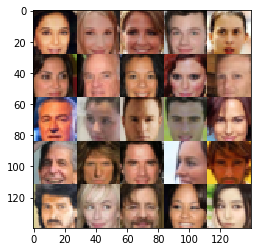

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # Define input paramter
    real_inputs = tf.placeholder(tf.float32,
                                 (None, image_width, image_height, image_channels), 
                                 name='real_inputs')
    
    z_input = tf.placeholder(tf.float32,
                             (None, z_dim),
                             name='z_inputs')
    
    lr = tf.placeholder(tf.float32,
                        name='learning_rate')
    
    return real_inputs, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Note that input layer is 28 x 28 x image_channel
    
    # Define leaky relu_function (alpha = 0.2)
    alpha = 0.2
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    # Define conv_layer function
    def conv_layer(inputs, filters, kernel_size, strides, batch_norm=True):
        hidden = tf.layers.conv2d(inputs,
                                  filters,
                                  kernel_size,
                                  strides,
                                  padding='same',
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        if batch_norm:
            hidden = tf.layers.batch_normalization(hidden, training=True)
        
        return tf.layers.dropout(leaky_relu(hidden), 0.3)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # First layer
        h0 = conv_layer(images, 64, 5, 2, batch_norm=False) # 14 x 14
        h1 = conv_layer(h0, 128, 5, 2) # 7 x 7
        h2 = conv_layer(h1, 256, 3, 2) # 4 x 4
        h2 = conv_layer(h1, 512, 3, 1) # 4 x 4
        
        # Logits and outputs
        flat = tf.reshape(h2, (-1, 4 * 4 * 512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # Define leaky relu_function (alpha = 0.2)
    alpha = 0.2
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    # Define initialiser
    k_init = tf.contrib.layers.xavier_initializer()
    
    # def deconv
    def deconv(inputs, filters, kernel_size, strides, training, init = k_init):
        
        dec_layer = tf.layers.conv2d_transpose(inputs,
                                               filters,
                                               kernel_size, 
                                               strides, 
                                               padding='same', 
                                               kernel_initializer=k_init)

        dec_layer = tf.layers.batch_normalization(dec_layer, training=training)
        
        # Apply dropout
        return tf.layers.dropout(leaky_relu(dec_layer), 0.5, training=training)
        
    with tf.variable_scope('generator', reuse=not is_train):
        
        
        h1 = tf.layers.dense(z, 7 * 7 * 512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = leaky_relu(h1) # 7 x 7
        
        h2 = deconv(h1, 256, 3, 2, training=is_train) # 14 x 14
        h3 = deconv(h2, 128, 5, 2, training=is_train) # 28 x 28
        h4 = deconv(h3, 64, 5, 1, training=is_train)
        
        logits = tf.layers.conv2d_transpose(h4, out_channel_dim, 5, 1, 'same') # 28 x 28
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Ouputs of generator and discriminator
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Smoothing factor
    smooth = 0.1
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * (1-smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list = d_vars)
        g_train = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Build input placeholders
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Define losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Definie optimisers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                # MNIST dataset is between -0.5 and 0.5. Need to fix it by multiplying by 2
                batch_images = batch_images * 2.0
           
                # Sample random data from the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimisers
                _ = sess.run(d_opt, feed_dict={input_real : batch_images, 
                                               input_z : batch_z, 
                                               lr : learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real : batch_images,
                                               input_z : batch_z, 
                                               lr : learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epoch_count),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 1.4064... Generator Loss: 1.0503
Epoch 1/2... Batch 20... Discriminator Loss: 1.1966... Generator Loss: 1.1706
Epoch 1/2... Batch 30... Discriminator Loss: 1.0354... Generator Loss: 1.2221
Epoch 1/2... Batch 40... Discriminator Loss: 1.0484... Generator Loss: 2.6650
Epoch 1/2... Batch 50... Discriminator Loss: 1.0549... Generator Loss: 2.6820
Epoch 1/2... Batch 60... Discriminator Loss: 0.9543... Generator Loss: 2.6311
Epoch 1/2... Batch 70... Discriminator Loss: 2.0254... Generator Loss: 0.9194
Epoch 1/2... Batch 80... Discriminator Loss: 1.8843... Generator Loss: 0.3194
Epoch 1/2... Batch 90... Discriminator Loss: 1.6510... Generator Loss: 0.3802
Epoch 1/2... Batch 100... Discriminator Loss: 1.3273... Generator Loss: 0.8794


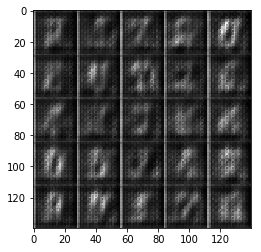

Epoch 1/2... Batch 110... Discriminator Loss: 1.3622... Generator Loss: 0.9561
Epoch 1/2... Batch 120... Discriminator Loss: 1.5871... Generator Loss: 1.6485
Epoch 1/2... Batch 130... Discriminator Loss: 1.4429... Generator Loss: 1.1063
Epoch 1/2... Batch 140... Discriminator Loss: 1.3338... Generator Loss: 1.2156
Epoch 1/2... Batch 150... Discriminator Loss: 1.3495... Generator Loss: 1.2617
Epoch 1/2... Batch 160... Discriminator Loss: 1.3952... Generator Loss: 1.3500
Epoch 1/2... Batch 170... Discriminator Loss: 1.3192... Generator Loss: 1.1446
Epoch 1/2... Batch 180... Discriminator Loss: 1.3326... Generator Loss: 1.1287
Epoch 1/2... Batch 190... Discriminator Loss: 1.3194... Generator Loss: 0.9787
Epoch 1/2... Batch 200... Discriminator Loss: 1.4762... Generator Loss: 1.5617


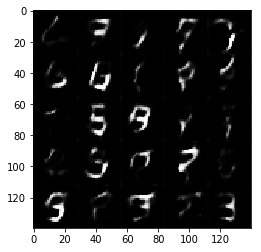

Epoch 1/2... Batch 210... Discriminator Loss: 1.3189... Generator Loss: 1.1905
Epoch 1/2... Batch 220... Discriminator Loss: 1.2285... Generator Loss: 0.8059
Epoch 1/2... Batch 230... Discriminator Loss: 1.4483... Generator Loss: 0.5364
Epoch 1/2... Batch 240... Discriminator Loss: 1.3671... Generator Loss: 0.5807
Epoch 1/2... Batch 250... Discriminator Loss: 1.3348... Generator Loss: 0.8505
Epoch 1/2... Batch 260... Discriminator Loss: 1.4298... Generator Loss: 1.5502
Epoch 1/2... Batch 270... Discriminator Loss: 1.3799... Generator Loss: 1.3615
Epoch 1/2... Batch 280... Discriminator Loss: 1.4282... Generator Loss: 1.1518
Epoch 1/2... Batch 290... Discriminator Loss: 1.2856... Generator Loss: 1.0355
Epoch 1/2... Batch 300... Discriminator Loss: 1.6208... Generator Loss: 1.6760


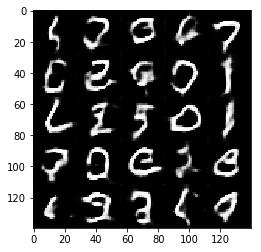

Epoch 1/2... Batch 310... Discriminator Loss: 1.3371... Generator Loss: 1.0883
Epoch 1/2... Batch 320... Discriminator Loss: 1.3182... Generator Loss: 1.0579
Epoch 1/2... Batch 330... Discriminator Loss: 1.2722... Generator Loss: 1.4695
Epoch 1/2... Batch 340... Discriminator Loss: 1.3030... Generator Loss: 1.0452
Epoch 1/2... Batch 350... Discriminator Loss: 1.2987... Generator Loss: 1.2306
Epoch 1/2... Batch 360... Discriminator Loss: 1.4025... Generator Loss: 1.3825
Epoch 1/2... Batch 370... Discriminator Loss: 1.3281... Generator Loss: 0.9200
Epoch 1/2... Batch 380... Discriminator Loss: 1.2647... Generator Loss: 0.8065
Epoch 1/2... Batch 390... Discriminator Loss: 1.3499... Generator Loss: 1.2992
Epoch 1/2... Batch 400... Discriminator Loss: 1.3886... Generator Loss: 1.2909


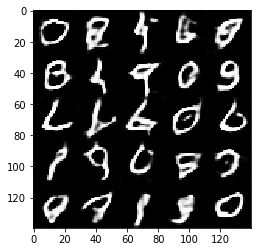

Epoch 1/2... Batch 410... Discriminator Loss: 1.3076... Generator Loss: 0.7943
Epoch 1/2... Batch 420... Discriminator Loss: 1.4842... Generator Loss: 0.4487
Epoch 1/2... Batch 430... Discriminator Loss: 1.3480... Generator Loss: 0.5965
Epoch 1/2... Batch 440... Discriminator Loss: 1.3709... Generator Loss: 0.8251
Epoch 1/2... Batch 450... Discriminator Loss: 1.4216... Generator Loss: 1.4333
Epoch 1/2... Batch 460... Discriminator Loss: 1.3259... Generator Loss: 1.1502
Epoch 1/2... Batch 470... Discriminator Loss: 1.2786... Generator Loss: 1.2149
Epoch 1/2... Batch 480... Discriminator Loss: 1.2533... Generator Loss: 0.8795
Epoch 1/2... Batch 490... Discriminator Loss: 1.6634... Generator Loss: 1.8112
Epoch 1/2... Batch 500... Discriminator Loss: 1.3138... Generator Loss: 1.1673


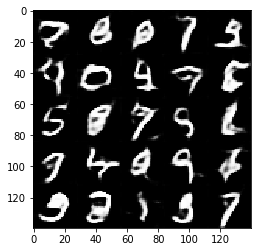

Epoch 1/2... Batch 510... Discriminator Loss: 1.3030... Generator Loss: 1.3795
Epoch 1/2... Batch 520... Discriminator Loss: 1.2554... Generator Loss: 1.1127
Epoch 1/2... Batch 530... Discriminator Loss: 1.3541... Generator Loss: 0.5663
Epoch 1/2... Batch 540... Discriminator Loss: 1.5367... Generator Loss: 0.4857
Epoch 1/2... Batch 550... Discriminator Loss: 1.4362... Generator Loss: 0.5119
Epoch 1/2... Batch 560... Discriminator Loss: 1.4387... Generator Loss: 0.5208
Epoch 1/2... Batch 570... Discriminator Loss: 1.2411... Generator Loss: 0.7663
Epoch 1/2... Batch 580... Discriminator Loss: 1.3455... Generator Loss: 0.6681
Epoch 1/2... Batch 590... Discriminator Loss: 1.2980... Generator Loss: 1.0038
Epoch 1/2... Batch 600... Discriminator Loss: 1.4503... Generator Loss: 1.2248


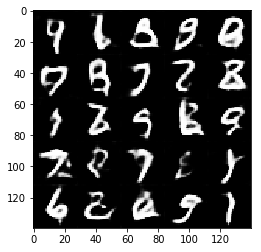

Epoch 1/2... Batch 610... Discriminator Loss: 1.3808... Generator Loss: 1.4334
Epoch 1/2... Batch 620... Discriminator Loss: 1.3432... Generator Loss: 1.2155
Epoch 1/2... Batch 630... Discriminator Loss: 1.3299... Generator Loss: 1.3542
Epoch 1/2... Batch 640... Discriminator Loss: 1.2981... Generator Loss: 0.9397
Epoch 1/2... Batch 650... Discriminator Loss: 1.3131... Generator Loss: 1.1108
Epoch 1/2... Batch 660... Discriminator Loss: 1.2454... Generator Loss: 0.8368
Epoch 1/2... Batch 670... Discriminator Loss: 1.4566... Generator Loss: 0.4629
Epoch 1/2... Batch 680... Discriminator Loss: 1.3482... Generator Loss: 0.5805
Epoch 1/2... Batch 690... Discriminator Loss: 1.2486... Generator Loss: 0.7529
Epoch 1/2... Batch 700... Discriminator Loss: 1.4136... Generator Loss: 0.5572


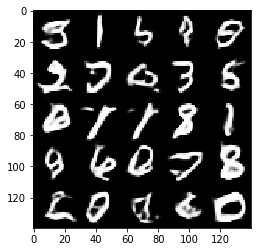

Epoch 1/2... Batch 710... Discriminator Loss: 1.2888... Generator Loss: 0.6700
Epoch 1/2... Batch 720... Discriminator Loss: 1.3340... Generator Loss: 0.6015
Epoch 1/2... Batch 730... Discriminator Loss: 1.3458... Generator Loss: 0.5523
Epoch 1/2... Batch 740... Discriminator Loss: 1.4174... Generator Loss: 0.6140
Epoch 1/2... Batch 750... Discriminator Loss: 1.2470... Generator Loss: 0.8595
Epoch 1/2... Batch 760... Discriminator Loss: 1.3123... Generator Loss: 0.9118
Epoch 1/2... Batch 770... Discriminator Loss: 1.6358... Generator Loss: 0.3657
Epoch 1/2... Batch 780... Discriminator Loss: 1.2637... Generator Loss: 0.7147
Epoch 1/2... Batch 790... Discriminator Loss: 1.3308... Generator Loss: 0.5818
Epoch 1/2... Batch 800... Discriminator Loss: 1.2624... Generator Loss: 0.6948


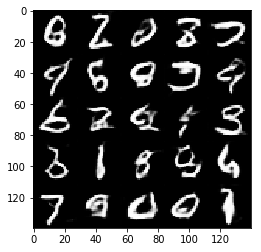

Epoch 1/2... Batch 810... Discriminator Loss: 1.4550... Generator Loss: 0.4969
Epoch 1/2... Batch 820... Discriminator Loss: 1.2048... Generator Loss: 0.8732
Epoch 1/2... Batch 830... Discriminator Loss: 1.4182... Generator Loss: 0.6926
Epoch 1/2... Batch 840... Discriminator Loss: 1.3510... Generator Loss: 0.5901
Epoch 1/2... Batch 850... Discriminator Loss: 1.4588... Generator Loss: 0.4867
Epoch 1/2... Batch 860... Discriminator Loss: 1.2092... Generator Loss: 0.8581
Epoch 1/2... Batch 870... Discriminator Loss: 1.4215... Generator Loss: 0.4586
Epoch 1/2... Batch 880... Discriminator Loss: 1.2602... Generator Loss: 0.7414
Epoch 1/2... Batch 890... Discriminator Loss: 1.4889... Generator Loss: 0.4615
Epoch 1/2... Batch 900... Discriminator Loss: 1.2865... Generator Loss: 0.6466


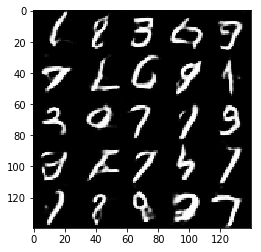

Epoch 1/2... Batch 910... Discriminator Loss: 1.4170... Generator Loss: 0.5031
Epoch 1/2... Batch 920... Discriminator Loss: 1.2298... Generator Loss: 0.8485
Epoch 1/2... Batch 930... Discriminator Loss: 1.3698... Generator Loss: 1.3646
Epoch 2/2... Batch 940... Discriminator Loss: 1.2948... Generator Loss: 1.3553
Epoch 2/2... Batch 950... Discriminator Loss: 1.3220... Generator Loss: 0.9904
Epoch 2/2... Batch 960... Discriminator Loss: 1.3541... Generator Loss: 0.5714
Epoch 2/2... Batch 970... Discriminator Loss: 1.2599... Generator Loss: 0.9510
Epoch 2/2... Batch 980... Discriminator Loss: 1.2903... Generator Loss: 1.4652
Epoch 2/2... Batch 990... Discriminator Loss: 1.3258... Generator Loss: 1.1529
Epoch 2/2... Batch 1000... Discriminator Loss: 1.2797... Generator Loss: 1.1675


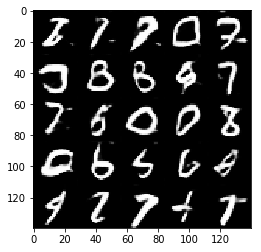

Epoch 2/2... Batch 1010... Discriminator Loss: 1.3616... Generator Loss: 0.5338
Epoch 2/2... Batch 1020... Discriminator Loss: 1.4967... Generator Loss: 0.5312
Epoch 2/2... Batch 1030... Discriminator Loss: 1.5782... Generator Loss: 0.9171
Epoch 2/2... Batch 1040... Discriminator Loss: 1.2936... Generator Loss: 0.6288
Epoch 2/2... Batch 1050... Discriminator Loss: 1.2673... Generator Loss: 0.7245
Epoch 2/2... Batch 1060... Discriminator Loss: 1.2863... Generator Loss: 0.6538
Epoch 2/2... Batch 1070... Discriminator Loss: 1.2687... Generator Loss: 1.0293
Epoch 2/2... Batch 1080... Discriminator Loss: 1.3849... Generator Loss: 1.5507
Epoch 2/2... Batch 1090... Discriminator Loss: 1.2529... Generator Loss: 1.0776
Epoch 2/2... Batch 1100... Discriminator Loss: 1.3462... Generator Loss: 0.7032


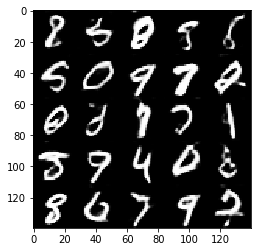

Epoch 2/2... Batch 1110... Discriminator Loss: 1.5315... Generator Loss: 0.9805
Epoch 2/2... Batch 1120... Discriminator Loss: 1.2573... Generator Loss: 0.7053
Epoch 2/2... Batch 1130... Discriminator Loss: 1.2439... Generator Loss: 0.9094
Epoch 2/2... Batch 1140... Discriminator Loss: 1.3507... Generator Loss: 1.4785
Epoch 2/2... Batch 1150... Discriminator Loss: 1.2910... Generator Loss: 1.2779
Epoch 2/2... Batch 1160... Discriminator Loss: 1.3276... Generator Loss: 1.4891
Epoch 2/2... Batch 1170... Discriminator Loss: 1.1980... Generator Loss: 1.0862
Epoch 2/2... Batch 1180... Discriminator Loss: 1.2667... Generator Loss: 1.3561
Epoch 2/2... Batch 1190... Discriminator Loss: 1.1990... Generator Loss: 0.8523
Epoch 2/2... Batch 1200... Discriminator Loss: 1.3957... Generator Loss: 1.2819


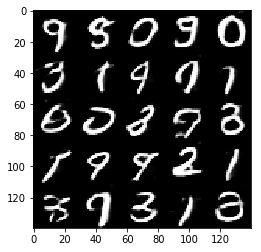

Epoch 2/2... Batch 1210... Discriminator Loss: 1.3102... Generator Loss: 1.2924
Epoch 2/2... Batch 1220... Discriminator Loss: 1.2292... Generator Loss: 1.2557
Epoch 2/2... Batch 1230... Discriminator Loss: 1.3066... Generator Loss: 1.3484
Epoch 2/2... Batch 1240... Discriminator Loss: 1.2701... Generator Loss: 1.2233
Epoch 2/2... Batch 1250... Discriminator Loss: 1.3550... Generator Loss: 1.6123
Epoch 2/2... Batch 1260... Discriminator Loss: 1.2283... Generator Loss: 1.3217
Epoch 2/2... Batch 1270... Discriminator Loss: 1.3327... Generator Loss: 1.6173
Epoch 2/2... Batch 1280... Discriminator Loss: 1.3005... Generator Loss: 1.4458
Epoch 2/2... Batch 1290... Discriminator Loss: 1.2201... Generator Loss: 0.7934
Epoch 2/2... Batch 1300... Discriminator Loss: 1.5486... Generator Loss: 0.4567


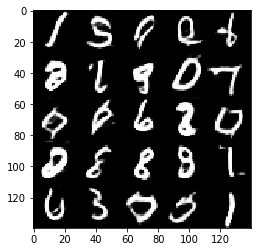

Epoch 2/2... Batch 1310... Discriminator Loss: 1.2737... Generator Loss: 0.8127
Epoch 2/2... Batch 1320... Discriminator Loss: 1.2631... Generator Loss: 0.6482
Epoch 2/2... Batch 1330... Discriminator Loss: 1.3536... Generator Loss: 0.6269
Epoch 2/2... Batch 1340... Discriminator Loss: 1.7396... Generator Loss: 0.8974
Epoch 2/2... Batch 1350... Discriminator Loss: 1.1945... Generator Loss: 1.0280
Epoch 2/2... Batch 1360... Discriminator Loss: 1.2545... Generator Loss: 1.0780
Epoch 2/2... Batch 1370... Discriminator Loss: 1.2817... Generator Loss: 1.2400
Epoch 2/2... Batch 1380... Discriminator Loss: 1.3460... Generator Loss: 1.4722
Epoch 2/2... Batch 1390... Discriminator Loss: 1.1896... Generator Loss: 1.1689
Epoch 2/2... Batch 1400... Discriminator Loss: 1.2466... Generator Loss: 1.1875


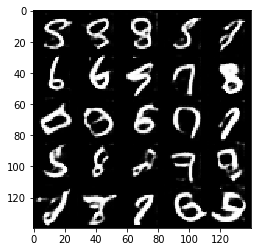

Epoch 2/2... Batch 1410... Discriminator Loss: 1.2055... Generator Loss: 0.9617
Epoch 2/2... Batch 1420... Discriminator Loss: 1.1821... Generator Loss: 0.9173
Epoch 2/2... Batch 1430... Discriminator Loss: 1.5510... Generator Loss: 0.4120
Epoch 2/2... Batch 1440... Discriminator Loss: 1.1881... Generator Loss: 0.8509
Epoch 2/2... Batch 1450... Discriminator Loss: 1.4522... Generator Loss: 1.4744
Epoch 2/2... Batch 1460... Discriminator Loss: 1.1526... Generator Loss: 0.9376
Epoch 2/2... Batch 1470... Discriminator Loss: 1.2714... Generator Loss: 0.6922
Epoch 2/2... Batch 1480... Discriminator Loss: 1.2121... Generator Loss: 0.7328
Epoch 2/2... Batch 1490... Discriminator Loss: 1.6547... Generator Loss: 0.3674
Epoch 2/2... Batch 1500... Discriminator Loss: 1.2540... Generator Loss: 0.7140


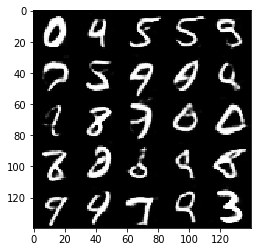

Epoch 2/2... Batch 1510... Discriminator Loss: 1.2485... Generator Loss: 0.6797
Epoch 2/2... Batch 1520... Discriminator Loss: 1.1595... Generator Loss: 0.9844
Epoch 2/2... Batch 1530... Discriminator Loss: 1.3312... Generator Loss: 0.5983
Epoch 2/2... Batch 1540... Discriminator Loss: 1.4224... Generator Loss: 0.6418
Epoch 2/2... Batch 1550... Discriminator Loss: 1.2047... Generator Loss: 0.9809
Epoch 2/2... Batch 1560... Discriminator Loss: 1.2599... Generator Loss: 0.8203
Epoch 2/2... Batch 1570... Discriminator Loss: 1.2178... Generator Loss: 0.7066
Epoch 2/2... Batch 1580... Discriminator Loss: 1.1883... Generator Loss: 1.0262
Epoch 2/2... Batch 1590... Discriminator Loss: 1.3209... Generator Loss: 1.3643
Epoch 2/2... Batch 1600... Discriminator Loss: 1.3859... Generator Loss: 1.4897


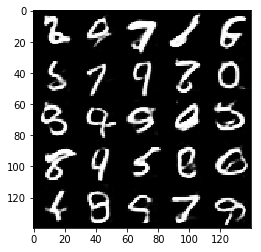

Epoch 2/2... Batch 1610... Discriminator Loss: 1.2313... Generator Loss: 1.1930
Epoch 2/2... Batch 1620... Discriminator Loss: 1.1828... Generator Loss: 0.8846
Epoch 2/2... Batch 1630... Discriminator Loss: 1.3664... Generator Loss: 0.5629
Epoch 2/2... Batch 1640... Discriminator Loss: 1.2803... Generator Loss: 0.6065
Epoch 2/2... Batch 1650... Discriminator Loss: 1.2317... Generator Loss: 0.8532
Epoch 2/2... Batch 1660... Discriminator Loss: 1.0822... Generator Loss: 1.1603
Epoch 2/2... Batch 1670... Discriminator Loss: 1.5338... Generator Loss: 1.8083
Epoch 2/2... Batch 1680... Discriminator Loss: 1.2256... Generator Loss: 1.0410
Epoch 2/2... Batch 1690... Discriminator Loss: 1.1529... Generator Loss: 0.8289
Epoch 2/2... Batch 1700... Discriminator Loss: 1.2752... Generator Loss: 0.6250


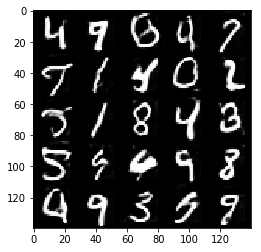

Epoch 2/2... Batch 1710... Discriminator Loss: 1.2098... Generator Loss: 1.0365
Epoch 2/2... Batch 1720... Discriminator Loss: 1.1638... Generator Loss: 0.8693
Epoch 2/2... Batch 1730... Discriminator Loss: 1.8723... Generator Loss: 1.0022
Epoch 2/2... Batch 1740... Discriminator Loss: 1.1868... Generator Loss: 0.7715
Epoch 2/2... Batch 1750... Discriminator Loss: 1.2114... Generator Loss: 0.6803
Epoch 2/2... Batch 1760... Discriminator Loss: 1.3893... Generator Loss: 0.5203
Epoch 2/2... Batch 1770... Discriminator Loss: 1.3748... Generator Loss: 0.5499
Epoch 2/2... Batch 1780... Discriminator Loss: 1.1481... Generator Loss: 0.8150
Epoch 2/2... Batch 1790... Discriminator Loss: 1.3663... Generator Loss: 0.5919
Epoch 2/2... Batch 1800... Discriminator Loss: 1.2569... Generator Loss: 0.7610


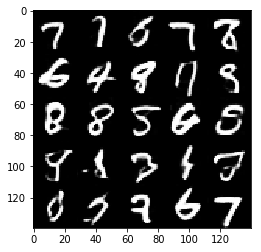

Epoch 2/2... Batch 1810... Discriminator Loss: 1.2804... Generator Loss: 1.1458
Epoch 2/2... Batch 1820... Discriminator Loss: 1.3720... Generator Loss: 0.5114
Epoch 2/2... Batch 1830... Discriminator Loss: 1.2124... Generator Loss: 0.8566
Epoch 2/2... Batch 1840... Discriminator Loss: 1.3316... Generator Loss: 0.5787
Epoch 2/2... Batch 1850... Discriminator Loss: 1.3088... Generator Loss: 0.6390
Epoch 2/2... Batch 1860... Discriminator Loss: 1.1811... Generator Loss: 0.7571
Epoch 2/2... Batch 1870... Discriminator Loss: 1.1343... Generator Loss: 0.8904


In [23]:
batch_size = 64
z_dim = 100
learning_rate = 1e-3
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.3855... Generator Loss: 0.9123
Epoch 1/1... Batch 20... Discriminator Loss: 1.4303... Generator Loss: 0.9143
Epoch 1/1... Batch 30... Discriminator Loss: 1.3075... Generator Loss: 0.9300
Epoch 1/1... Batch 40... Discriminator Loss: 1.2435... Generator Loss: 0.9468
Epoch 1/1... Batch 50... Discriminator Loss: 1.2347... Generator Loss: 1.0979
Epoch 1/1... Batch 60... Discriminator Loss: 1.2527... Generator Loss: 1.0317
Epoch 1/1... Batch 70... Discriminator Loss: 1.1649... Generator Loss: 1.0745
Epoch 1/1... Batch 80... Discriminator Loss: 1.1576... Generator Loss: 0.9494
Epoch 1/1... Batch 90... Discriminator Loss: 1.1203... Generator Loss: 1.1657
Epoch 1/1... Batch 100... Discriminator Loss: 0.9440... Generator Loss: 1.3398


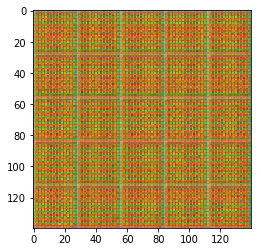

Epoch 1/1... Batch 110... Discriminator Loss: 0.9371... Generator Loss: 1.4091
Epoch 1/1... Batch 120... Discriminator Loss: 0.8584... Generator Loss: 1.3821
Epoch 1/1... Batch 130... Discriminator Loss: 0.9140... Generator Loss: 1.3825
Epoch 1/1... Batch 140... Discriminator Loss: 0.9423... Generator Loss: 1.4118
Epoch 1/1... Batch 150... Discriminator Loss: 0.8319... Generator Loss: 1.5416
Epoch 1/1... Batch 160... Discriminator Loss: 0.7667... Generator Loss: 1.4920
Epoch 1/1... Batch 170... Discriminator Loss: 0.8378... Generator Loss: 1.4831
Epoch 1/1... Batch 180... Discriminator Loss: 0.8385... Generator Loss: 1.3358
Epoch 1/1... Batch 190... Discriminator Loss: 0.9652... Generator Loss: 1.1979
Epoch 1/1... Batch 200... Discriminator Loss: 0.9481... Generator Loss: 1.5867


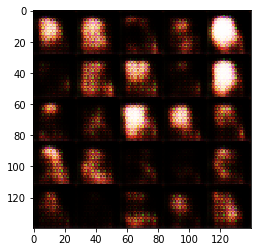

Epoch 1/1... Batch 210... Discriminator Loss: 0.9195... Generator Loss: 1.7051
Epoch 1/1... Batch 220... Discriminator Loss: 0.6390... Generator Loss: 1.6960
Epoch 1/1... Batch 230... Discriminator Loss: 0.6693... Generator Loss: 1.8012
Epoch 1/1... Batch 240... Discriminator Loss: 0.7725... Generator Loss: 1.6335
Epoch 1/1... Batch 250... Discriminator Loss: 0.5713... Generator Loss: 2.2579
Epoch 1/1... Batch 260... Discriminator Loss: 0.5300... Generator Loss: 2.1917
Epoch 1/1... Batch 270... Discriminator Loss: 1.3416... Generator Loss: 2.1027
Epoch 1/1... Batch 280... Discriminator Loss: 0.5348... Generator Loss: 2.2506
Epoch 1/1... Batch 290... Discriminator Loss: 0.5341... Generator Loss: 2.2995
Epoch 1/1... Batch 300... Discriminator Loss: 0.4536... Generator Loss: 2.5807


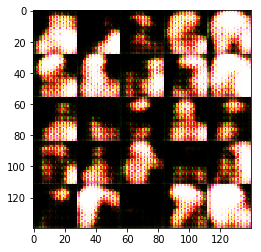

Epoch 1/1... Batch 310... Discriminator Loss: 0.4853... Generator Loss: 2.4007
Epoch 1/1... Batch 320... Discriminator Loss: 0.5457... Generator Loss: 2.0603
Epoch 1/1... Batch 330... Discriminator Loss: 0.6219... Generator Loss: 1.8124
Epoch 1/1... Batch 340... Discriminator Loss: 0.5746... Generator Loss: 1.9727
Epoch 1/1... Batch 350... Discriminator Loss: 0.6107... Generator Loss: 2.2133
Epoch 1/1... Batch 360... Discriminator Loss: 0.8823... Generator Loss: 1.1704
Epoch 1/1... Batch 370... Discriminator Loss: 0.7299... Generator Loss: 2.0396
Epoch 1/1... Batch 380... Discriminator Loss: 0.5752... Generator Loss: 1.7552
Epoch 1/1... Batch 390... Discriminator Loss: 0.6862... Generator Loss: 1.9617
Epoch 1/1... Batch 400... Discriminator Loss: 0.8412... Generator Loss: 1.4033


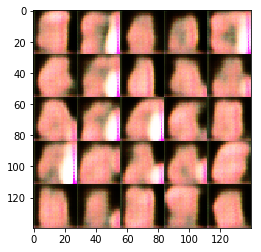

Epoch 1/1... Batch 410... Discriminator Loss: 0.7147... Generator Loss: 1.6903
Epoch 1/1... Batch 420... Discriminator Loss: 0.6336... Generator Loss: 1.7691
Epoch 1/1... Batch 430... Discriminator Loss: 0.6042... Generator Loss: 1.7449
Epoch 1/1... Batch 440... Discriminator Loss: 0.6350... Generator Loss: 1.6958
Epoch 1/1... Batch 450... Discriminator Loss: 0.7769... Generator Loss: 1.4031
Epoch 1/1... Batch 460... Discriminator Loss: 0.5563... Generator Loss: 1.8806
Epoch 1/1... Batch 470... Discriminator Loss: 0.7001... Generator Loss: 1.8339
Epoch 1/1... Batch 480... Discriminator Loss: 0.5724... Generator Loss: 1.8447
Epoch 1/1... Batch 490... Discriminator Loss: 0.8566... Generator Loss: 1.4576
Epoch 1/1... Batch 500... Discriminator Loss: 0.5392... Generator Loss: 1.9551


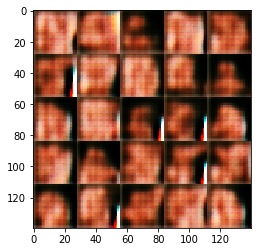

Epoch 1/1... Batch 510... Discriminator Loss: 0.5263... Generator Loss: 2.1166
Epoch 1/1... Batch 520... Discriminator Loss: 0.6020... Generator Loss: 2.0046
Epoch 1/1... Batch 530... Discriminator Loss: 0.5419... Generator Loss: 2.0019
Epoch 1/1... Batch 540... Discriminator Loss: 0.7903... Generator Loss: 1.8799
Epoch 1/1... Batch 550... Discriminator Loss: 0.4989... Generator Loss: 2.1771
Epoch 1/1... Batch 560... Discriminator Loss: 0.5677... Generator Loss: 1.8065
Epoch 1/1... Batch 570... Discriminator Loss: 0.5446... Generator Loss: 1.9116
Epoch 1/1... Batch 580... Discriminator Loss: 1.1925... Generator Loss: 1.3243
Epoch 1/1... Batch 590... Discriminator Loss: 1.4117... Generator Loss: 1.8078
Epoch 1/1... Batch 600... Discriminator Loss: 0.7224... Generator Loss: 1.6415


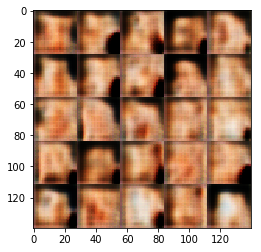

Epoch 1/1... Batch 610... Discriminator Loss: 0.7031... Generator Loss: 1.5019
Epoch 1/1... Batch 620... Discriminator Loss: 0.7166... Generator Loss: 1.4179
Epoch 1/1... Batch 630... Discriminator Loss: 0.9346... Generator Loss: 1.0080
Epoch 1/1... Batch 640... Discriminator Loss: 0.7278... Generator Loss: 1.3247
Epoch 1/1... Batch 650... Discriminator Loss: 0.5414... Generator Loss: 2.5356
Epoch 1/1... Batch 660... Discriminator Loss: 0.5774... Generator Loss: 1.7398
Epoch 1/1... Batch 670... Discriminator Loss: 0.7519... Generator Loss: 1.4905
Epoch 1/1... Batch 680... Discriminator Loss: 0.6004... Generator Loss: 1.9386
Epoch 1/1... Batch 690... Discriminator Loss: 1.0265... Generator Loss: 1.0106
Epoch 1/1... Batch 700... Discriminator Loss: 0.9552... Generator Loss: 1.0222


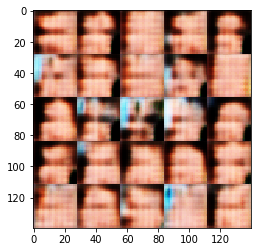

Epoch 1/1... Batch 710... Discriminator Loss: 1.2891... Generator Loss: 1.4121
Epoch 1/1... Batch 720... Discriminator Loss: 1.9105... Generator Loss: 0.7526
Epoch 1/1... Batch 730... Discriminator Loss: 1.1302... Generator Loss: 0.9287
Epoch 1/1... Batch 740... Discriminator Loss: 0.9303... Generator Loss: 1.2039
Epoch 1/1... Batch 750... Discriminator Loss: 0.8980... Generator Loss: 1.3748
Epoch 1/1... Batch 760... Discriminator Loss: 0.9443... Generator Loss: 1.2569
Epoch 1/1... Batch 770... Discriminator Loss: 1.0028... Generator Loss: 1.1278
Epoch 1/1... Batch 780... Discriminator Loss: 1.3473... Generator Loss: 0.5702
Epoch 1/1... Batch 790... Discriminator Loss: 0.9689... Generator Loss: 1.4496
Epoch 1/1... Batch 800... Discriminator Loss: 1.1746... Generator Loss: 1.2657


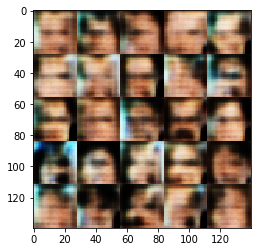

Epoch 1/1... Batch 810... Discriminator Loss: 0.9598... Generator Loss: 1.4913
Epoch 1/1... Batch 820... Discriminator Loss: 0.9915... Generator Loss: 1.1962
Epoch 1/1... Batch 830... Discriminator Loss: 0.9238... Generator Loss: 1.1016
Epoch 1/1... Batch 840... Discriminator Loss: 1.3214... Generator Loss: 0.7470
Epoch 1/1... Batch 850... Discriminator Loss: 0.8313... Generator Loss: 1.2248
Epoch 1/1... Batch 860... Discriminator Loss: 1.1930... Generator Loss: 1.0425
Epoch 1/1... Batch 870... Discriminator Loss: 1.1814... Generator Loss: 1.1052
Epoch 1/1... Batch 880... Discriminator Loss: 1.0171... Generator Loss: 1.2386
Epoch 1/1... Batch 890... Discriminator Loss: 0.9326... Generator Loss: 1.2015
Epoch 1/1... Batch 900... Discriminator Loss: 0.9221... Generator Loss: 1.4798


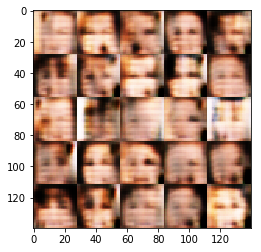

Epoch 1/1... Batch 910... Discriminator Loss: 1.0974... Generator Loss: 0.9761
Epoch 1/1... Batch 920... Discriminator Loss: 0.9789... Generator Loss: 1.2896
Epoch 1/1... Batch 930... Discriminator Loss: 0.9369... Generator Loss: 1.3887
Epoch 1/1... Batch 940... Discriminator Loss: 0.9055... Generator Loss: 1.4154
Epoch 1/1... Batch 950... Discriminator Loss: 0.9872... Generator Loss: 1.0274
Epoch 1/1... Batch 960... Discriminator Loss: 1.0417... Generator Loss: 1.1430
Epoch 1/1... Batch 970... Discriminator Loss: 0.8303... Generator Loss: 1.5598
Epoch 1/1... Batch 980... Discriminator Loss: 1.2920... Generator Loss: 1.2354
Epoch 1/1... Batch 990... Discriminator Loss: 1.1636... Generator Loss: 0.9091
Epoch 1/1... Batch 1000... Discriminator Loss: 1.0097... Generator Loss: 0.9758


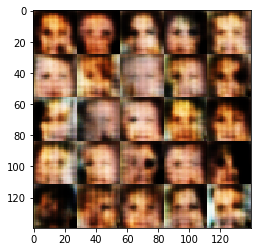

Epoch 1/1... Batch 1010... Discriminator Loss: 1.0560... Generator Loss: 1.2822
Epoch 1/1... Batch 1020... Discriminator Loss: 1.2349... Generator Loss: 1.2608
Epoch 1/1... Batch 1030... Discriminator Loss: 1.0539... Generator Loss: 0.9228
Epoch 1/1... Batch 1040... Discriminator Loss: 1.2362... Generator Loss: 0.7448
Epoch 1/1... Batch 1050... Discriminator Loss: 0.9436... Generator Loss: 1.1679
Epoch 1/1... Batch 1060... Discriminator Loss: 1.0071... Generator Loss: 1.4543
Epoch 1/1... Batch 1070... Discriminator Loss: 1.1965... Generator Loss: 0.9761
Epoch 1/1... Batch 1080... Discriminator Loss: 1.0018... Generator Loss: 0.9523
Epoch 1/1... Batch 1090... Discriminator Loss: 0.9506... Generator Loss: 1.3044
Epoch 1/1... Batch 1100... Discriminator Loss: 0.9524... Generator Loss: 1.1293


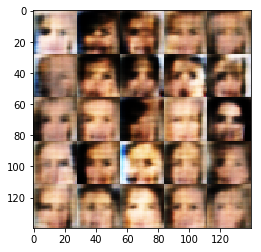

Epoch 1/1... Batch 1110... Discriminator Loss: 1.0325... Generator Loss: 1.0487
Epoch 1/1... Batch 1120... Discriminator Loss: 1.0724... Generator Loss: 1.3514
Epoch 1/1... Batch 1130... Discriminator Loss: 1.0890... Generator Loss: 1.1044
Epoch 1/1... Batch 1140... Discriminator Loss: 1.1776... Generator Loss: 1.3924
Epoch 1/1... Batch 1150... Discriminator Loss: 1.1204... Generator Loss: 1.3141
Epoch 1/1... Batch 1160... Discriminator Loss: 1.1745... Generator Loss: 0.9522
Epoch 1/1... Batch 1170... Discriminator Loss: 1.0163... Generator Loss: 1.1256
Epoch 1/1... Batch 1180... Discriminator Loss: 1.4131... Generator Loss: 0.8686
Epoch 1/1... Batch 1190... Discriminator Loss: 1.0134... Generator Loss: 1.1518
Epoch 1/1... Batch 1200... Discriminator Loss: 1.1828... Generator Loss: 1.0805


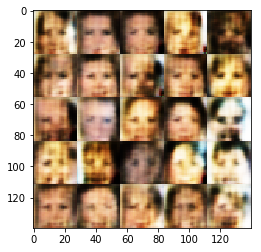

Epoch 1/1... Batch 1210... Discriminator Loss: 1.1724... Generator Loss: 1.0169
Epoch 1/1... Batch 1220... Discriminator Loss: 1.0171... Generator Loss: 1.1733
Epoch 1/1... Batch 1230... Discriminator Loss: 1.3077... Generator Loss: 1.1165
Epoch 1/1... Batch 1240... Discriminator Loss: 1.2550... Generator Loss: 0.9473
Epoch 1/1... Batch 1250... Discriminator Loss: 1.0511... Generator Loss: 1.0751
Epoch 1/1... Batch 1260... Discriminator Loss: 1.2747... Generator Loss: 0.7017
Epoch 1/1... Batch 1270... Discriminator Loss: 1.2096... Generator Loss: 1.1808
Epoch 1/1... Batch 1280... Discriminator Loss: 1.2561... Generator Loss: 0.6199
Epoch 1/1... Batch 1290... Discriminator Loss: 1.1647... Generator Loss: 1.0820
Epoch 1/1... Batch 1300... Discriminator Loss: 0.9878... Generator Loss: 1.0908


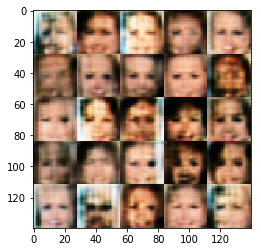

Epoch 1/1... Batch 1310... Discriminator Loss: 1.2054... Generator Loss: 0.9014
Epoch 1/1... Batch 1320... Discriminator Loss: 1.1157... Generator Loss: 0.9162
Epoch 1/1... Batch 1330... Discriminator Loss: 0.9777... Generator Loss: 1.1093
Epoch 1/1... Batch 1340... Discriminator Loss: 1.1438... Generator Loss: 0.7844
Epoch 1/1... Batch 1350... Discriminator Loss: 1.1747... Generator Loss: 1.3835
Epoch 1/1... Batch 1360... Discriminator Loss: 1.1246... Generator Loss: 1.0355
Epoch 1/1... Batch 1370... Discriminator Loss: 1.1223... Generator Loss: 1.0824
Epoch 1/1... Batch 1380... Discriminator Loss: 1.6011... Generator Loss: 0.4177
Epoch 1/1... Batch 1390... Discriminator Loss: 1.0961... Generator Loss: 0.9596
Epoch 1/1... Batch 1400... Discriminator Loss: 1.0884... Generator Loss: 0.9522


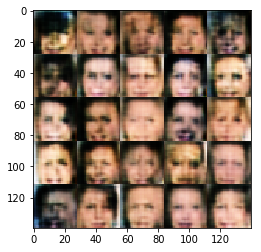

Epoch 1/1... Batch 1410... Discriminator Loss: 1.4065... Generator Loss: 0.8757
Epoch 1/1... Batch 1420... Discriminator Loss: 1.1301... Generator Loss: 1.1145
Epoch 1/1... Batch 1430... Discriminator Loss: 1.1205... Generator Loss: 0.9879
Epoch 1/1... Batch 1440... Discriminator Loss: 1.1974... Generator Loss: 1.0657
Epoch 1/1... Batch 1450... Discriminator Loss: 1.3222... Generator Loss: 0.8501
Epoch 1/1... Batch 1460... Discriminator Loss: 1.1821... Generator Loss: 1.0148
Epoch 1/1... Batch 1470... Discriminator Loss: 1.1473... Generator Loss: 1.1008
Epoch 1/1... Batch 1480... Discriminator Loss: 1.0707... Generator Loss: 1.1810
Epoch 1/1... Batch 1490... Discriminator Loss: 1.0636... Generator Loss: 1.2080
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2119... Generator Loss: 1.0028


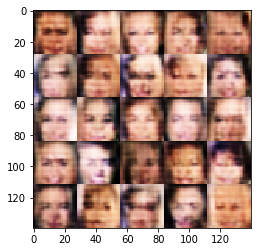

Epoch 1/1... Batch 1510... Discriminator Loss: 1.1455... Generator Loss: 0.8511
Epoch 1/1... Batch 1520... Discriminator Loss: 1.1047... Generator Loss: 1.1325
Epoch 1/1... Batch 1530... Discriminator Loss: 1.1170... Generator Loss: 0.9186
Epoch 1/1... Batch 1540... Discriminator Loss: 1.2317... Generator Loss: 0.7421
Epoch 1/1... Batch 1550... Discriminator Loss: 1.2752... Generator Loss: 0.8214
Epoch 1/1... Batch 1560... Discriminator Loss: 1.1372... Generator Loss: 1.0433
Epoch 1/1... Batch 1570... Discriminator Loss: 1.1911... Generator Loss: 1.0372
Epoch 1/1... Batch 1580... Discriminator Loss: 1.1885... Generator Loss: 1.0946
Epoch 1/1... Batch 1590... Discriminator Loss: 1.1384... Generator Loss: 1.0077
Epoch 1/1... Batch 1600... Discriminator Loss: 1.2343... Generator Loss: 0.9182


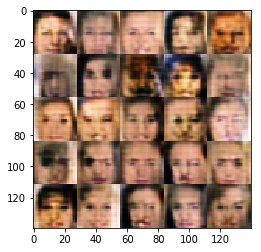

Epoch 1/1... Batch 1610... Discriminator Loss: 1.1814... Generator Loss: 0.9188
Epoch 1/1... Batch 1620... Discriminator Loss: 1.0911... Generator Loss: 1.2134
Epoch 1/1... Batch 1630... Discriminator Loss: 1.1668... Generator Loss: 1.0541
Epoch 1/1... Batch 1640... Discriminator Loss: 1.3390... Generator Loss: 0.6633
Epoch 1/1... Batch 1650... Discriminator Loss: 1.1613... Generator Loss: 1.1560
Epoch 1/1... Batch 1660... Discriminator Loss: 0.9540... Generator Loss: 1.1370
Epoch 1/1... Batch 1670... Discriminator Loss: 1.1093... Generator Loss: 0.9707
Epoch 1/1... Batch 1680... Discriminator Loss: 1.2239... Generator Loss: 1.1689
Epoch 1/1... Batch 1690... Discriminator Loss: 1.0610... Generator Loss: 1.0821
Epoch 1/1... Batch 1700... Discriminator Loss: 1.2335... Generator Loss: 0.8424


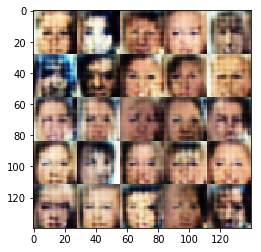

Epoch 1/1... Batch 1710... Discriminator Loss: 1.2676... Generator Loss: 0.8488
Epoch 1/1... Batch 1720... Discriminator Loss: 1.2777... Generator Loss: 0.7637
Epoch 1/1... Batch 1730... Discriminator Loss: 1.2267... Generator Loss: 0.9767
Epoch 1/1... Batch 1740... Discriminator Loss: 1.2166... Generator Loss: 1.0521
Epoch 1/1... Batch 1750... Discriminator Loss: 1.0430... Generator Loss: 1.0639
Epoch 1/1... Batch 1760... Discriminator Loss: 1.2681... Generator Loss: 0.9707
Epoch 1/1... Batch 1770... Discriminator Loss: 1.1778... Generator Loss: 1.0538
Epoch 1/1... Batch 1780... Discriminator Loss: 1.1649... Generator Loss: 1.0256
Epoch 1/1... Batch 1790... Discriminator Loss: 1.0425... Generator Loss: 1.1737
Epoch 1/1... Batch 1800... Discriminator Loss: 1.3027... Generator Loss: 1.0050


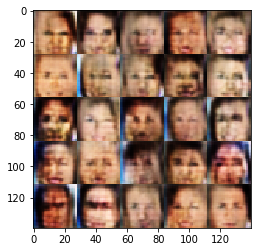

Epoch 1/1... Batch 1810... Discriminator Loss: 1.3919... Generator Loss: 0.8737
Epoch 1/1... Batch 1820... Discriminator Loss: 1.2473... Generator Loss: 1.0175
Epoch 1/1... Batch 1830... Discriminator Loss: 1.1368... Generator Loss: 1.0238
Epoch 1/1... Batch 1840... Discriminator Loss: 1.4514... Generator Loss: 0.7279
Epoch 1/1... Batch 1850... Discriminator Loss: 1.2321... Generator Loss: 0.8776
Epoch 1/1... Batch 1860... Discriminator Loss: 1.1921... Generator Loss: 0.9781
Epoch 1/1... Batch 1870... Discriminator Loss: 1.0970... Generator Loss: 0.9159
Epoch 1/1... Batch 1880... Discriminator Loss: 1.1389... Generator Loss: 0.8922
Epoch 1/1... Batch 1890... Discriminator Loss: 1.1628... Generator Loss: 0.9310
Epoch 1/1... Batch 1900... Discriminator Loss: 1.3248... Generator Loss: 0.9345


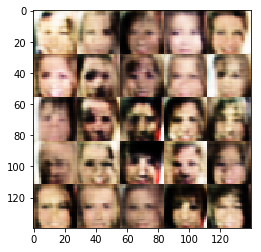

Epoch 1/1... Batch 1910... Discriminator Loss: 1.2262... Generator Loss: 0.9164
Epoch 1/1... Batch 1920... Discriminator Loss: 1.2004... Generator Loss: 1.0996
Epoch 1/1... Batch 1930... Discriminator Loss: 1.1025... Generator Loss: 0.9626
Epoch 1/1... Batch 1940... Discriminator Loss: 1.2553... Generator Loss: 0.7791
Epoch 1/1... Batch 1950... Discriminator Loss: 1.0475... Generator Loss: 1.0402
Epoch 1/1... Batch 1960... Discriminator Loss: 1.1283... Generator Loss: 1.0610
Epoch 1/1... Batch 1970... Discriminator Loss: 1.1369... Generator Loss: 1.0357
Epoch 1/1... Batch 1980... Discriminator Loss: 1.1794... Generator Loss: 0.9035
Epoch 1/1... Batch 1990... Discriminator Loss: 1.3295... Generator Loss: 0.7904
Epoch 1/1... Batch 2000... Discriminator Loss: 1.2277... Generator Loss: 1.1222


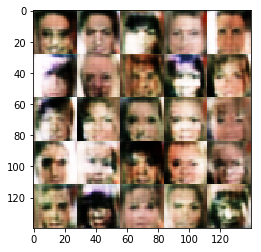

Epoch 1/1... Batch 2010... Discriminator Loss: 1.3666... Generator Loss: 0.9059
Epoch 1/1... Batch 2020... Discriminator Loss: 1.1331... Generator Loss: 1.0339
Epoch 1/1... Batch 2030... Discriminator Loss: 1.2176... Generator Loss: 0.8116
Epoch 1/1... Batch 2040... Discriminator Loss: 1.1274... Generator Loss: 0.9257
Epoch 1/1... Batch 2050... Discriminator Loss: 1.2231... Generator Loss: 0.7469
Epoch 1/1... Batch 2060... Discriminator Loss: 1.4910... Generator Loss: 0.7396
Epoch 1/1... Batch 2070... Discriminator Loss: 1.2057... Generator Loss: 1.0013
Epoch 1/1... Batch 2080... Discriminator Loss: 1.2719... Generator Loss: 0.8716
Epoch 1/1... Batch 2090... Discriminator Loss: 1.1044... Generator Loss: 1.0508
Epoch 1/1... Batch 2100... Discriminator Loss: 1.0507... Generator Loss: 0.9819


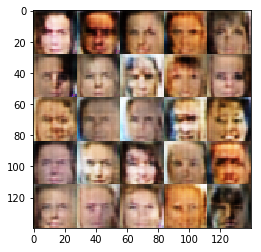

Epoch 1/1... Batch 2110... Discriminator Loss: 1.2741... Generator Loss: 0.9720
Epoch 1/1... Batch 2120... Discriminator Loss: 1.4524... Generator Loss: 0.7086
Epoch 1/1... Batch 2130... Discriminator Loss: 1.1639... Generator Loss: 1.0627
Epoch 1/1... Batch 2140... Discriminator Loss: 1.0070... Generator Loss: 1.1122
Epoch 1/1... Batch 2150... Discriminator Loss: 1.1212... Generator Loss: 1.1089
Epoch 1/1... Batch 2160... Discriminator Loss: 1.1735... Generator Loss: 1.0387
Epoch 1/1... Batch 2170... Discriminator Loss: 1.2760... Generator Loss: 0.7704
Epoch 1/1... Batch 2180... Discriminator Loss: 1.2570... Generator Loss: 0.7876
Epoch 1/1... Batch 2190... Discriminator Loss: 1.3058... Generator Loss: 0.7834
Epoch 1/1... Batch 2200... Discriminator Loss: 1.2830... Generator Loss: 0.9922


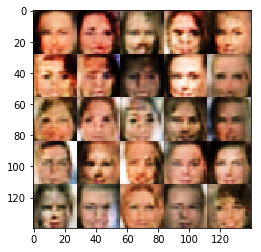

Epoch 1/1... Batch 2210... Discriminator Loss: 1.5201... Generator Loss: 0.6399
Epoch 1/1... Batch 2220... Discriminator Loss: 1.1487... Generator Loss: 1.0018
Epoch 1/1... Batch 2230... Discriminator Loss: 1.2112... Generator Loss: 0.8001
Epoch 1/1... Batch 2240... Discriminator Loss: 1.5708... Generator Loss: 0.5640
Epoch 1/1... Batch 2250... Discriminator Loss: 1.3737... Generator Loss: 0.7543
Epoch 1/1... Batch 2260... Discriminator Loss: 1.1856... Generator Loss: 1.0365
Epoch 1/1... Batch 2270... Discriminator Loss: 1.0342... Generator Loss: 1.0721
Epoch 1/1... Batch 2280... Discriminator Loss: 1.5207... Generator Loss: 1.2968
Epoch 1/1... Batch 2290... Discriminator Loss: 1.1737... Generator Loss: 0.9946
Epoch 1/1... Batch 2300... Discriminator Loss: 1.0387... Generator Loss: 1.0774


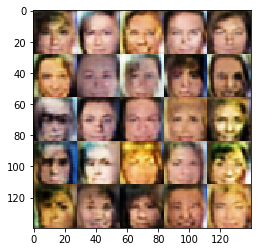

Epoch 1/1... Batch 2310... Discriminator Loss: 1.1516... Generator Loss: 0.9926
Epoch 1/1... Batch 2320... Discriminator Loss: 1.1367... Generator Loss: 0.8417
Epoch 1/1... Batch 2330... Discriminator Loss: 1.0553... Generator Loss: 1.0734
Epoch 1/1... Batch 2340... Discriminator Loss: 1.2740... Generator Loss: 0.8037
Epoch 1/1... Batch 2350... Discriminator Loss: 1.1902... Generator Loss: 0.9380
Epoch 1/1... Batch 2360... Discriminator Loss: 1.1181... Generator Loss: 0.9964
Epoch 1/1... Batch 2370... Discriminator Loss: 1.2442... Generator Loss: 0.8270
Epoch 1/1... Batch 2380... Discriminator Loss: 1.2982... Generator Loss: 0.8476
Epoch 1/1... Batch 2390... Discriminator Loss: 1.2147... Generator Loss: 1.0705
Epoch 1/1... Batch 2400... Discriminator Loss: 1.1876... Generator Loss: 0.8415


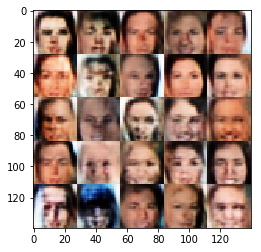

Epoch 1/1... Batch 2410... Discriminator Loss: 1.1489... Generator Loss: 0.9987
Epoch 1/1... Batch 2420... Discriminator Loss: 1.2233... Generator Loss: 0.8676
Epoch 1/1... Batch 2430... Discriminator Loss: 1.1772... Generator Loss: 0.9821
Epoch 1/1... Batch 2440... Discriminator Loss: 1.1612... Generator Loss: 1.0330
Epoch 1/1... Batch 2450... Discriminator Loss: 1.3195... Generator Loss: 0.9238
Epoch 1/1... Batch 2460... Discriminator Loss: 1.1889... Generator Loss: 0.9154
Epoch 1/1... Batch 2470... Discriminator Loss: 1.2040... Generator Loss: 0.8822
Epoch 1/1... Batch 2480... Discriminator Loss: 1.1120... Generator Loss: 0.8432
Epoch 1/1... Batch 2490... Discriminator Loss: 1.1149... Generator Loss: 0.9436
Epoch 1/1... Batch 2500... Discriminator Loss: 1.1164... Generator Loss: 1.0629


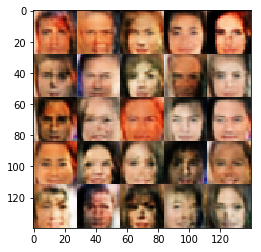

Epoch 1/1... Batch 2510... Discriminator Loss: 1.1686... Generator Loss: 1.0264
Epoch 1/1... Batch 2520... Discriminator Loss: 1.0409... Generator Loss: 1.2130
Epoch 1/1... Batch 2530... Discriminator Loss: 0.9666... Generator Loss: 1.1691
Epoch 1/1... Batch 2540... Discriminator Loss: 1.1385... Generator Loss: 0.9152
Epoch 1/1... Batch 2550... Discriminator Loss: 1.3139... Generator Loss: 0.8643
Epoch 1/1... Batch 2560... Discriminator Loss: 1.1716... Generator Loss: 0.9250
Epoch 1/1... Batch 2570... Discriminator Loss: 1.2007... Generator Loss: 1.0284
Epoch 1/1... Batch 2580... Discriminator Loss: 1.1753... Generator Loss: 0.9368
Epoch 1/1... Batch 2590... Discriminator Loss: 1.2268... Generator Loss: 0.7790
Epoch 1/1... Batch 2600... Discriminator Loss: 1.2967... Generator Loss: 0.7797


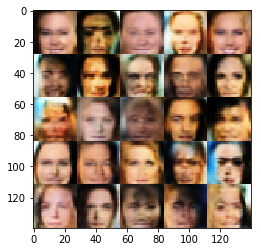

Epoch 1/1... Batch 2610... Discriminator Loss: 1.1538... Generator Loss: 1.0364
Epoch 1/1... Batch 2620... Discriminator Loss: 1.2242... Generator Loss: 0.8050
Epoch 1/1... Batch 2630... Discriminator Loss: 1.2847... Generator Loss: 0.7519
Epoch 1/1... Batch 2640... Discriminator Loss: 1.3101... Generator Loss: 0.8225
Epoch 1/1... Batch 2650... Discriminator Loss: 1.4849... Generator Loss: 0.7997
Epoch 1/1... Batch 2660... Discriminator Loss: 1.3281... Generator Loss: 0.7370
Epoch 1/1... Batch 2670... Discriminator Loss: 1.3174... Generator Loss: 0.7455
Epoch 1/1... Batch 2680... Discriminator Loss: 1.1681... Generator Loss: 1.0060
Epoch 1/1... Batch 2690... Discriminator Loss: 1.2316... Generator Loss: 0.9425
Epoch 1/1... Batch 2700... Discriminator Loss: 1.1195... Generator Loss: 0.9301


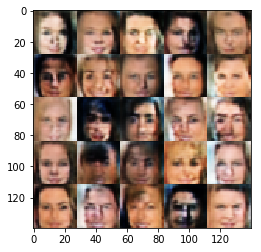

Epoch 1/1... Batch 2710... Discriminator Loss: 1.0840... Generator Loss: 1.0426
Epoch 1/1... Batch 2720... Discriminator Loss: 1.2256... Generator Loss: 0.9277
Epoch 1/1... Batch 2730... Discriminator Loss: 1.1499... Generator Loss: 0.9582
Epoch 1/1... Batch 2740... Discriminator Loss: 1.1163... Generator Loss: 0.9112
Epoch 1/1... Batch 2750... Discriminator Loss: 1.1810... Generator Loss: 0.9586
Epoch 1/1... Batch 2760... Discriminator Loss: 0.9836... Generator Loss: 1.1214
Epoch 1/1... Batch 2770... Discriminator Loss: 1.2285... Generator Loss: 0.9371
Epoch 1/1... Batch 2780... Discriminator Loss: 1.2085... Generator Loss: 0.8934
Epoch 1/1... Batch 2790... Discriminator Loss: 1.0033... Generator Loss: 1.2516
Epoch 1/1... Batch 2800... Discriminator Loss: 1.4600... Generator Loss: 0.6424


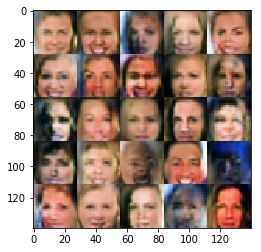

Epoch 1/1... Batch 2810... Discriminator Loss: 1.2495... Generator Loss: 0.8894
Epoch 1/1... Batch 2820... Discriminator Loss: 1.3721... Generator Loss: 0.6976
Epoch 1/1... Batch 2830... Discriminator Loss: 1.2555... Generator Loss: 0.8779
Epoch 1/1... Batch 2840... Discriminator Loss: 1.2136... Generator Loss: 0.8255
Epoch 1/1... Batch 2850... Discriminator Loss: 1.2466... Generator Loss: 0.8709
Epoch 1/1... Batch 2860... Discriminator Loss: 1.3526... Generator Loss: 0.7882
Epoch 1/1... Batch 2870... Discriminator Loss: 1.0615... Generator Loss: 1.0513
Epoch 1/1... Batch 2880... Discriminator Loss: 1.5494... Generator Loss: 0.6732
Epoch 1/1... Batch 2890... Discriminator Loss: 1.1918... Generator Loss: 0.9796
Epoch 1/1... Batch 2900... Discriminator Loss: 1.1373... Generator Loss: 0.9973


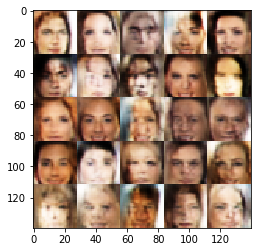

Epoch 1/1... Batch 2910... Discriminator Loss: 1.2504... Generator Loss: 0.8264
Epoch 1/1... Batch 2920... Discriminator Loss: 1.3387... Generator Loss: 0.9269
Epoch 1/1... Batch 2930... Discriminator Loss: 1.1360... Generator Loss: 0.8729
Epoch 1/1... Batch 2940... Discriminator Loss: 1.0679... Generator Loss: 0.9427
Epoch 1/1... Batch 2950... Discriminator Loss: 1.0602... Generator Loss: 1.0407
Epoch 1/1... Batch 2960... Discriminator Loss: 1.1952... Generator Loss: 0.9488
Epoch 1/1... Batch 2970... Discriminator Loss: 1.1685... Generator Loss: 0.9376
Epoch 1/1... Batch 2980... Discriminator Loss: 1.1212... Generator Loss: 0.9972
Epoch 1/1... Batch 2990... Discriminator Loss: 1.4152... Generator Loss: 0.6935
Epoch 1/1... Batch 3000... Discriminator Loss: 1.1427... Generator Loss: 0.9477


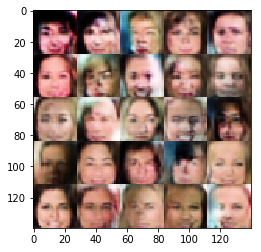

Epoch 1/1... Batch 3010... Discriminator Loss: 1.2407... Generator Loss: 0.7997
Epoch 1/1... Batch 3020... Discriminator Loss: 1.1058... Generator Loss: 1.0148
Epoch 1/1... Batch 3030... Discriminator Loss: 1.4046... Generator Loss: 0.8565
Epoch 1/1... Batch 3040... Discriminator Loss: 1.2303... Generator Loss: 1.0693
Epoch 1/1... Batch 3050... Discriminator Loss: 1.3593... Generator Loss: 0.8741
Epoch 1/1... Batch 3060... Discriminator Loss: 1.2317... Generator Loss: 0.8887
Epoch 1/1... Batch 3070... Discriminator Loss: 1.3318... Generator Loss: 0.8292
Epoch 1/1... Batch 3080... Discriminator Loss: 0.9833... Generator Loss: 1.0844
Epoch 1/1... Batch 3090... Discriminator Loss: 1.1826... Generator Loss: 0.8995
Epoch 1/1... Batch 3100... Discriminator Loss: 1.3895... Generator Loss: 0.7430


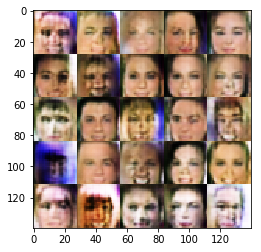

Epoch 1/1... Batch 3110... Discriminator Loss: 1.1600... Generator Loss: 1.1520
Epoch 1/1... Batch 3120... Discriminator Loss: 1.1937... Generator Loss: 0.9897
Epoch 1/1... Batch 3130... Discriminator Loss: 1.3459... Generator Loss: 0.8156
Epoch 1/1... Batch 3140... Discriminator Loss: 1.2547... Generator Loss: 0.6936
Epoch 1/1... Batch 3150... Discriminator Loss: 1.2686... Generator Loss: 0.8918
Epoch 1/1... Batch 3160... Discriminator Loss: 1.1671... Generator Loss: 0.9871
Epoch 1/1... Batch 3170... Discriminator Loss: 1.2752... Generator Loss: 0.8882
Epoch 1/1... Batch 3180... Discriminator Loss: 1.1059... Generator Loss: 0.9561
Epoch 1/1... Batch 3190... Discriminator Loss: 1.1957... Generator Loss: 0.9165
Epoch 1/1... Batch 3200... Discriminator Loss: 1.2729... Generator Loss: 0.8157


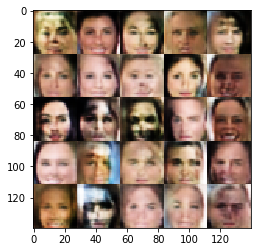

Epoch 1/1... Batch 3210... Discriminator Loss: 1.1890... Generator Loss: 0.9124
Epoch 1/1... Batch 3220... Discriminator Loss: 1.3219... Generator Loss: 0.8564
Epoch 1/1... Batch 3230... Discriminator Loss: 1.2307... Generator Loss: 0.9693
Epoch 1/1... Batch 3240... Discriminator Loss: 1.2548... Generator Loss: 0.8727
Epoch 1/1... Batch 3250... Discriminator Loss: 1.3965... Generator Loss: 0.7131
Epoch 1/1... Batch 3260... Discriminator Loss: 1.3127... Generator Loss: 0.9077
Epoch 1/1... Batch 3270... Discriminator Loss: 1.1927... Generator Loss: 0.9534
Epoch 1/1... Batch 3280... Discriminator Loss: 1.1676... Generator Loss: 0.8974
Epoch 1/1... Batch 3290... Discriminator Loss: 1.1857... Generator Loss: 0.9037
Epoch 1/1... Batch 3300... Discriminator Loss: 1.2907... Generator Loss: 0.9264


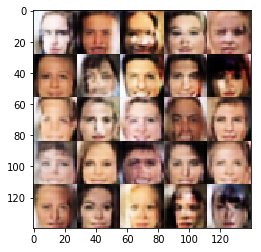

Epoch 1/1... Batch 3310... Discriminator Loss: 1.5977... Generator Loss: 0.7745
Epoch 1/1... Batch 3320... Discriminator Loss: 1.2454... Generator Loss: 0.8746
Epoch 1/1... Batch 3330... Discriminator Loss: 1.1405... Generator Loss: 1.0335
Epoch 1/1... Batch 3340... Discriminator Loss: 1.1462... Generator Loss: 0.9514
Epoch 1/1... Batch 3350... Discriminator Loss: 1.1629... Generator Loss: 0.9774
Epoch 1/1... Batch 3360... Discriminator Loss: 1.1012... Generator Loss: 1.1856
Epoch 1/1... Batch 3370... Discriminator Loss: 1.1900... Generator Loss: 0.9844
Epoch 1/1... Batch 3380... Discriminator Loss: 1.0676... Generator Loss: 1.0957
Epoch 1/1... Batch 3390... Discriminator Loss: 1.3304... Generator Loss: 1.0324
Epoch 1/1... Batch 3400... Discriminator Loss: 1.4134... Generator Loss: 0.7260


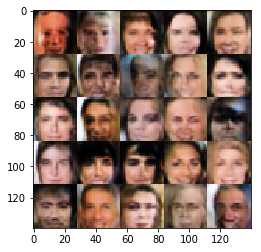

Epoch 1/1... Batch 3410... Discriminator Loss: 1.1611... Generator Loss: 1.0111
Epoch 1/1... Batch 3420... Discriminator Loss: 1.1648... Generator Loss: 0.9880
Epoch 1/1... Batch 3430... Discriminator Loss: 1.1550... Generator Loss: 0.9031
Epoch 1/1... Batch 3440... Discriminator Loss: 1.0875... Generator Loss: 0.9462
Epoch 1/1... Batch 3450... Discriminator Loss: 1.3550... Generator Loss: 0.8485
Epoch 1/1... Batch 3460... Discriminator Loss: 1.2704... Generator Loss: 0.8889
Epoch 1/1... Batch 3470... Discriminator Loss: 1.1965... Generator Loss: 0.8851
Epoch 1/1... Batch 3480... Discriminator Loss: 1.2379... Generator Loss: 0.9193
Epoch 1/1... Batch 3490... Discriminator Loss: 1.1681... Generator Loss: 0.8468
Epoch 1/1... Batch 3500... Discriminator Loss: 1.1494... Generator Loss: 0.9416


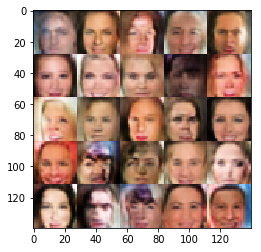

Epoch 1/1... Batch 3510... Discriminator Loss: 1.3377... Generator Loss: 0.9509
Epoch 1/1... Batch 3520... Discriminator Loss: 1.1483... Generator Loss: 0.9876
Epoch 1/1... Batch 3530... Discriminator Loss: 1.3218... Generator Loss: 0.8173
Epoch 1/1... Batch 3540... Discriminator Loss: 1.3709... Generator Loss: 0.8283
Epoch 1/1... Batch 3550... Discriminator Loss: 1.3216... Generator Loss: 0.9602
Epoch 1/1... Batch 3560... Discriminator Loss: 1.0598... Generator Loss: 0.9730
Epoch 1/1... Batch 3570... Discriminator Loss: 1.5551... Generator Loss: 0.6125
Epoch 1/1... Batch 3580... Discriminator Loss: 1.1761... Generator Loss: 0.9296
Epoch 1/1... Batch 3590... Discriminator Loss: 1.2401... Generator Loss: 0.8557
Epoch 1/1... Batch 3600... Discriminator Loss: 1.3241... Generator Loss: 0.7771


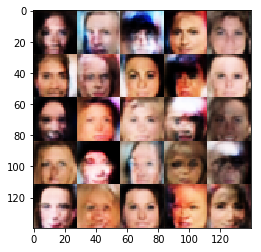

Epoch 1/1... Batch 3610... Discriminator Loss: 1.2497... Generator Loss: 0.8620
Epoch 1/1... Batch 3620... Discriminator Loss: 1.1984... Generator Loss: 1.0004
Epoch 1/1... Batch 3630... Discriminator Loss: 1.5950... Generator Loss: 0.5948
Epoch 1/1... Batch 3640... Discriminator Loss: 1.2150... Generator Loss: 0.9964
Epoch 1/1... Batch 3650... Discriminator Loss: 1.2218... Generator Loss: 0.8089
Epoch 1/1... Batch 3660... Discriminator Loss: 1.3512... Generator Loss: 0.8848
Epoch 1/1... Batch 3670... Discriminator Loss: 1.3756... Generator Loss: 0.7120
Epoch 1/1... Batch 3680... Discriminator Loss: 1.0540... Generator Loss: 1.1673
Epoch 1/1... Batch 3690... Discriminator Loss: 1.2416... Generator Loss: 0.9136
Epoch 1/1... Batch 3700... Discriminator Loss: 1.2349... Generator Loss: 1.0910


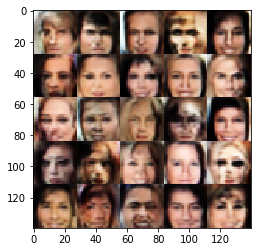

Epoch 1/1... Batch 3710... Discriminator Loss: 1.1468... Generator Loss: 0.9508
Epoch 1/1... Batch 3720... Discriminator Loss: 1.0776... Generator Loss: 1.0045
Epoch 1/1... Batch 3730... Discriminator Loss: 1.3518... Generator Loss: 0.8101
Epoch 1/1... Batch 3740... Discriminator Loss: 1.1171... Generator Loss: 1.0050
Epoch 1/1... Batch 3750... Discriminator Loss: 1.2059... Generator Loss: 0.8738
Epoch 1/1... Batch 3760... Discriminator Loss: 1.2400... Generator Loss: 0.8659
Epoch 1/1... Batch 3770... Discriminator Loss: 1.1615... Generator Loss: 0.8677
Epoch 1/1... Batch 3780... Discriminator Loss: 1.2380... Generator Loss: 1.0971
Epoch 1/1... Batch 3790... Discriminator Loss: 1.1774... Generator Loss: 0.9583
Epoch 1/1... Batch 3800... Discriminator Loss: 1.1635... Generator Loss: 0.9634


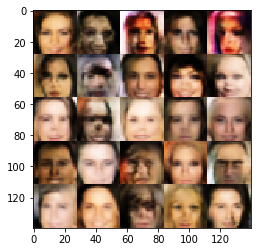

Epoch 1/1... Batch 3810... Discriminator Loss: 1.2741... Generator Loss: 0.8498
Epoch 1/1... Batch 3820... Discriminator Loss: 1.1512... Generator Loss: 0.9826
Epoch 1/1... Batch 3830... Discriminator Loss: 1.2079... Generator Loss: 0.8861
Epoch 1/1... Batch 3840... Discriminator Loss: 1.1955... Generator Loss: 0.8501
Epoch 1/1... Batch 3850... Discriminator Loss: 1.2276... Generator Loss: 0.9234
Epoch 1/1... Batch 3860... Discriminator Loss: 1.1611... Generator Loss: 1.0392
Epoch 1/1... Batch 3870... Discriminator Loss: 1.2438... Generator Loss: 0.8926
Epoch 1/1... Batch 3880... Discriminator Loss: 1.2799... Generator Loss: 1.0029
Epoch 1/1... Batch 3890... Discriminator Loss: 1.1111... Generator Loss: 1.0613
Epoch 1/1... Batch 3900... Discriminator Loss: 1.1689... Generator Loss: 0.9710


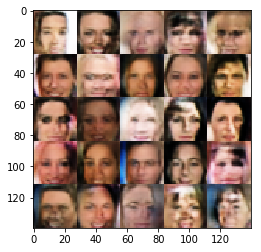

Epoch 1/1... Batch 3910... Discriminator Loss: 1.2220... Generator Loss: 0.8537
Epoch 1/1... Batch 3920... Discriminator Loss: 1.2135... Generator Loss: 0.8830
Epoch 1/1... Batch 3930... Discriminator Loss: 1.1884... Generator Loss: 0.9804
Epoch 1/1... Batch 3940... Discriminator Loss: 1.1286... Generator Loss: 1.0831
Epoch 1/1... Batch 3950... Discriminator Loss: 1.2188... Generator Loss: 0.9349
Epoch 1/1... Batch 3960... Discriminator Loss: 1.0286... Generator Loss: 1.0573
Epoch 1/1... Batch 3970... Discriminator Loss: 1.1207... Generator Loss: 1.1076
Epoch 1/1... Batch 3980... Discriminator Loss: 1.3826... Generator Loss: 0.9172
Epoch 1/1... Batch 3990... Discriminator Loss: 1.1637... Generator Loss: 0.8277
Epoch 1/1... Batch 4000... Discriminator Loss: 1.2206... Generator Loss: 0.9770


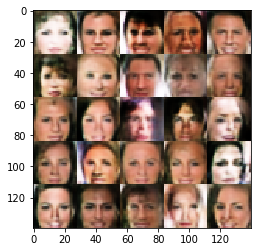

Epoch 1/1... Batch 4010... Discriminator Loss: 1.2396... Generator Loss: 0.9454
Epoch 1/1... Batch 4020... Discriminator Loss: 1.2161... Generator Loss: 0.9339
Epoch 1/1... Batch 4030... Discriminator Loss: 1.0834... Generator Loss: 0.9704
Epoch 1/1... Batch 4040... Discriminator Loss: 1.2940... Generator Loss: 0.8437
Epoch 1/1... Batch 4050... Discriminator Loss: 1.2101... Generator Loss: 0.9359
Epoch 1/1... Batch 4060... Discriminator Loss: 1.2968... Generator Loss: 0.9156
Epoch 1/1... Batch 4070... Discriminator Loss: 1.2564... Generator Loss: 0.9105
Epoch 1/1... Batch 4080... Discriminator Loss: 1.1503... Generator Loss: 0.9724
Epoch 1/1... Batch 4090... Discriminator Loss: 1.3198... Generator Loss: 0.8981
Epoch 1/1... Batch 4100... Discriminator Loss: 1.2228... Generator Loss: 0.9639


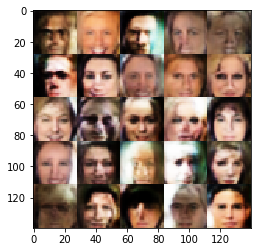

Epoch 1/1... Batch 4110... Discriminator Loss: 1.5783... Generator Loss: 0.6459
Epoch 1/1... Batch 4120... Discriminator Loss: 1.1919... Generator Loss: 0.8208
Epoch 1/1... Batch 4130... Discriminator Loss: 1.2280... Generator Loss: 0.9037
Epoch 1/1... Batch 4140... Discriminator Loss: 1.0957... Generator Loss: 0.9798
Epoch 1/1... Batch 4150... Discriminator Loss: 1.2330... Generator Loss: 0.8578
Epoch 1/1... Batch 4160... Discriminator Loss: 1.1475... Generator Loss: 0.8820
Epoch 1/1... Batch 4170... Discriminator Loss: 1.2570... Generator Loss: 0.9206
Epoch 1/1... Batch 4180... Discriminator Loss: 1.1789... Generator Loss: 0.8364
Epoch 1/1... Batch 4190... Discriminator Loss: 1.2670... Generator Loss: 0.8415
Epoch 1/1... Batch 4200... Discriminator Loss: 1.1911... Generator Loss: 0.8876


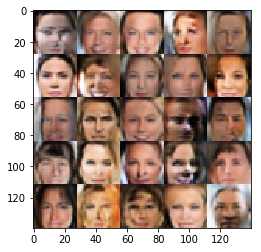

Epoch 1/1... Batch 4210... Discriminator Loss: 1.3149... Generator Loss: 0.7586
Epoch 1/1... Batch 4220... Discriminator Loss: 1.1156... Generator Loss: 0.9583
Epoch 1/1... Batch 4230... Discriminator Loss: 1.3170... Generator Loss: 0.8602
Epoch 1/1... Batch 4240... Discriminator Loss: 1.1849... Generator Loss: 1.0163
Epoch 1/1... Batch 4250... Discriminator Loss: 1.4913... Generator Loss: 0.8670
Epoch 1/1... Batch 4260... Discriminator Loss: 0.9989... Generator Loss: 1.0427
Epoch 1/1... Batch 4270... Discriminator Loss: 1.0853... Generator Loss: 1.1311
Epoch 1/1... Batch 4280... Discriminator Loss: 1.1865... Generator Loss: 1.0631
Epoch 1/1... Batch 4290... Discriminator Loss: 1.2051... Generator Loss: 0.9954
Epoch 1/1... Batch 4300... Discriminator Loss: 1.4488... Generator Loss: 0.7038


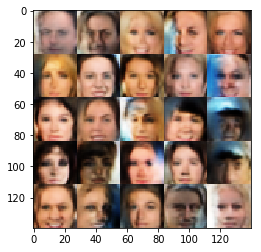

Epoch 1/1... Batch 4310... Discriminator Loss: 1.2627... Generator Loss: 0.9089
Epoch 1/1... Batch 4320... Discriminator Loss: 1.2727... Generator Loss: 0.8224
Epoch 1/1... Batch 4330... Discriminator Loss: 1.1917... Generator Loss: 0.9044
Epoch 1/1... Batch 4340... Discriminator Loss: 1.0931... Generator Loss: 0.9181
Epoch 1/1... Batch 4350... Discriminator Loss: 1.1517... Generator Loss: 1.0124
Epoch 1/1... Batch 4360... Discriminator Loss: 1.2866... Generator Loss: 0.9016
Epoch 1/1... Batch 4370... Discriminator Loss: 1.2683... Generator Loss: 0.8060
Epoch 1/1... Batch 4380... Discriminator Loss: 1.4974... Generator Loss: 0.6417
Epoch 1/1... Batch 4390... Discriminator Loss: 1.1598... Generator Loss: 0.9594
Epoch 1/1... Batch 4400... Discriminator Loss: 1.2394... Generator Loss: 0.8800


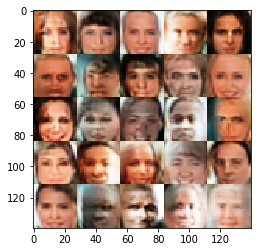

Epoch 1/1... Batch 4410... Discriminator Loss: 1.3114... Generator Loss: 0.7799
Epoch 1/1... Batch 4420... Discriminator Loss: 1.1492... Generator Loss: 0.9641
Epoch 1/1... Batch 4430... Discriminator Loss: 1.2652... Generator Loss: 0.9516
Epoch 1/1... Batch 4440... Discriminator Loss: 1.2709... Generator Loss: 0.8855
Epoch 1/1... Batch 4450... Discriminator Loss: 1.2786... Generator Loss: 0.9277
Epoch 1/1... Batch 4460... Discriminator Loss: 1.3241... Generator Loss: 0.8448
Epoch 1/1... Batch 4470... Discriminator Loss: 1.2555... Generator Loss: 0.8465
Epoch 1/1... Batch 4480... Discriminator Loss: 1.2248... Generator Loss: 0.8686
Epoch 1/1... Batch 4490... Discriminator Loss: 1.2908... Generator Loss: 0.9033
Epoch 1/1... Batch 4500... Discriminator Loss: 1.2743... Generator Loss: 0.7733


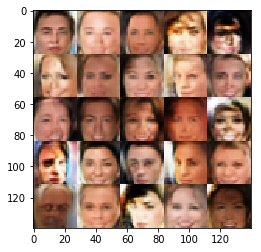

Epoch 1/1... Batch 4510... Discriminator Loss: 1.2907... Generator Loss: 0.9688
Epoch 1/1... Batch 4520... Discriminator Loss: 1.2971... Generator Loss: 0.9316
Epoch 1/1... Batch 4530... Discriminator Loss: 1.1452... Generator Loss: 1.0941
Epoch 1/1... Batch 4540... Discriminator Loss: 1.2440... Generator Loss: 0.9912
Epoch 1/1... Batch 4550... Discriminator Loss: 1.2918... Generator Loss: 0.8343
Epoch 1/1... Batch 4560... Discriminator Loss: 1.0424... Generator Loss: 1.0596
Epoch 1/1... Batch 4570... Discriminator Loss: 1.2965... Generator Loss: 0.8123
Epoch 1/1... Batch 4580... Discriminator Loss: 1.3847... Generator Loss: 0.8388
Epoch 1/1... Batch 4590... Discriminator Loss: 1.1728... Generator Loss: 0.9757
Epoch 1/1... Batch 4600... Discriminator Loss: 1.1506... Generator Loss: 1.0364


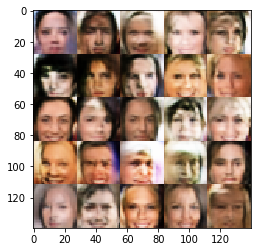

Epoch 1/1... Batch 4610... Discriminator Loss: 0.9965... Generator Loss: 1.0464
Epoch 1/1... Batch 4620... Discriminator Loss: 1.3509... Generator Loss: 0.8279
Epoch 1/1... Batch 4630... Discriminator Loss: 1.1551... Generator Loss: 1.0474
Epoch 1/1... Batch 4640... Discriminator Loss: 1.2831... Generator Loss: 0.8744
Epoch 1/1... Batch 4650... Discriminator Loss: 1.2497... Generator Loss: 0.8562
Epoch 1/1... Batch 4660... Discriminator Loss: 1.4400... Generator Loss: 0.6957
Epoch 1/1... Batch 4670... Discriminator Loss: 1.5292... Generator Loss: 0.8142
Epoch 1/1... Batch 4680... Discriminator Loss: 1.2438... Generator Loss: 0.8717
Epoch 1/1... Batch 4690... Discriminator Loss: 1.1516... Generator Loss: 0.8466
Epoch 1/1... Batch 4700... Discriminator Loss: 1.1340... Generator Loss: 0.9793


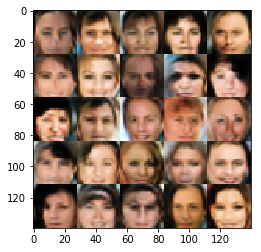

Epoch 1/1... Batch 4710... Discriminator Loss: 1.1449... Generator Loss: 0.8996
Epoch 1/1... Batch 4720... Discriminator Loss: 1.1356... Generator Loss: 0.8554
Epoch 1/1... Batch 4730... Discriminator Loss: 1.2728... Generator Loss: 0.8596
Epoch 1/1... Batch 4740... Discriminator Loss: 1.1130... Generator Loss: 1.0964
Epoch 1/1... Batch 4750... Discriminator Loss: 1.2583... Generator Loss: 0.8760
Epoch 1/1... Batch 4760... Discriminator Loss: 1.1250... Generator Loss: 0.8854
Epoch 1/1... Batch 4770... Discriminator Loss: 1.1693... Generator Loss: 0.8341
Epoch 1/1... Batch 4780... Discriminator Loss: 1.1596... Generator Loss: 1.0753
Epoch 1/1... Batch 4790... Discriminator Loss: 1.2383... Generator Loss: 1.0479
Epoch 1/1... Batch 4800... Discriminator Loss: 1.2673... Generator Loss: 0.8204


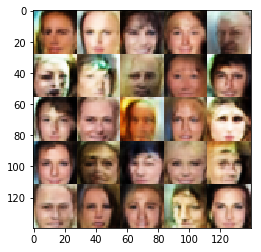

Epoch 1/1... Batch 4810... Discriminator Loss: 1.1982... Generator Loss: 0.9887
Epoch 1/1... Batch 4820... Discriminator Loss: 1.0859... Generator Loss: 1.1034
Epoch 1/1... Batch 4830... Discriminator Loss: 1.2464... Generator Loss: 0.7619
Epoch 1/1... Batch 4840... Discriminator Loss: 1.1312... Generator Loss: 1.0682
Epoch 1/1... Batch 4850... Discriminator Loss: 1.0556... Generator Loss: 1.0749
Epoch 1/1... Batch 4860... Discriminator Loss: 1.2391... Generator Loss: 0.9614
Epoch 1/1... Batch 4870... Discriminator Loss: 1.1651... Generator Loss: 0.8428
Epoch 1/1... Batch 4880... Discriminator Loss: 1.1546... Generator Loss: 0.9826
Epoch 1/1... Batch 4890... Discriminator Loss: 1.2707... Generator Loss: 0.8858
Epoch 1/1... Batch 4900... Discriminator Loss: 1.2373... Generator Loss: 0.8582


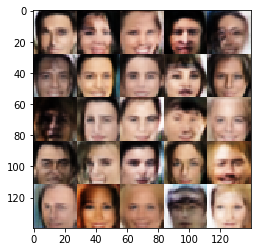

Epoch 1/1... Batch 4910... Discriminator Loss: 1.0593... Generator Loss: 1.0902
Epoch 1/1... Batch 4920... Discriminator Loss: 1.1749... Generator Loss: 0.8304
Epoch 1/1... Batch 4930... Discriminator Loss: 1.3490... Generator Loss: 0.7964
Epoch 1/1... Batch 4940... Discriminator Loss: 1.1938... Generator Loss: 0.8749
Epoch 1/1... Batch 4950... Discriminator Loss: 1.2325... Generator Loss: 0.9943
Epoch 1/1... Batch 4960... Discriminator Loss: 1.4541... Generator Loss: 1.0689
Epoch 1/1... Batch 4970... Discriminator Loss: 1.1800... Generator Loss: 0.9460
Epoch 1/1... Batch 4980... Discriminator Loss: 1.1547... Generator Loss: 0.9931
Epoch 1/1... Batch 4990... Discriminator Loss: 1.2080... Generator Loss: 0.9596
Epoch 1/1... Batch 5000... Discriminator Loss: 1.1622... Generator Loss: 0.9776


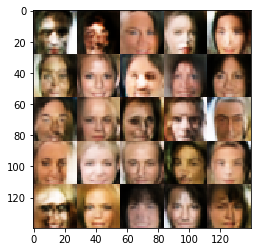

Epoch 1/1... Batch 5010... Discriminator Loss: 1.2905... Generator Loss: 0.8339
Epoch 1/1... Batch 5020... Discriminator Loss: 1.2587... Generator Loss: 0.9149
Epoch 1/1... Batch 5030... Discriminator Loss: 1.1833... Generator Loss: 1.0125
Epoch 1/1... Batch 5040... Discriminator Loss: 1.2729... Generator Loss: 0.8058
Epoch 1/1... Batch 5050... Discriminator Loss: 1.2559... Generator Loss: 0.9912
Epoch 1/1... Batch 5060... Discriminator Loss: 1.1851... Generator Loss: 0.9046
Epoch 1/1... Batch 5070... Discriminator Loss: 1.0962... Generator Loss: 0.9718
Epoch 1/1... Batch 5080... Discriminator Loss: 1.0871... Generator Loss: 1.0221
Epoch 1/1... Batch 5090... Discriminator Loss: 1.2661... Generator Loss: 0.9877
Epoch 1/1... Batch 5100... Discriminator Loss: 1.2457... Generator Loss: 0.8632


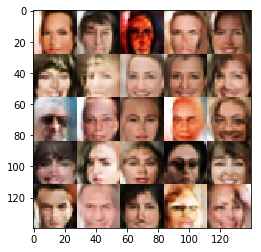

Epoch 1/1... Batch 5110... Discriminator Loss: 1.1424... Generator Loss: 0.9056
Epoch 1/1... Batch 5120... Discriminator Loss: 1.3552... Generator Loss: 0.8366
Epoch 1/1... Batch 5130... Discriminator Loss: 1.2544... Generator Loss: 0.9541
Epoch 1/1... Batch 5140... Discriminator Loss: 1.3452... Generator Loss: 0.7763
Epoch 1/1... Batch 5150... Discriminator Loss: 1.3209... Generator Loss: 0.9185
Epoch 1/1... Batch 5160... Discriminator Loss: 1.3859... Generator Loss: 0.8450
Epoch 1/1... Batch 5170... Discriminator Loss: 1.2436... Generator Loss: 0.8976
Epoch 1/1... Batch 5180... Discriminator Loss: 1.2175... Generator Loss: 0.8216
Epoch 1/1... Batch 5190... Discriminator Loss: 1.2535... Generator Loss: 0.8200
Epoch 1/1... Batch 5200... Discriminator Loss: 1.1266... Generator Loss: 0.9095


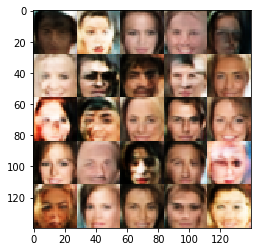

Epoch 1/1... Batch 5210... Discriminator Loss: 1.2216... Generator Loss: 0.8907
Epoch 1/1... Batch 5220... Discriminator Loss: 1.2914... Generator Loss: 0.9286
Epoch 1/1... Batch 5230... Discriminator Loss: 1.2833... Generator Loss: 0.8585
Epoch 1/1... Batch 5240... Discriminator Loss: 1.4618... Generator Loss: 0.8660
Epoch 1/1... Batch 5250... Discriminator Loss: 1.2276... Generator Loss: 0.8036
Epoch 1/1... Batch 5260... Discriminator Loss: 1.1969... Generator Loss: 0.8746
Epoch 1/1... Batch 5270... Discriminator Loss: 1.1996... Generator Loss: 0.8889
Epoch 1/1... Batch 5280... Discriminator Loss: 1.2225... Generator Loss: 0.9450
Epoch 1/1... Batch 5290... Discriminator Loss: 1.3193... Generator Loss: 0.7724
Epoch 1/1... Batch 5300... Discriminator Loss: 1.1890... Generator Loss: 0.9098


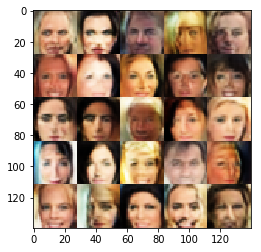

Epoch 1/1... Batch 5310... Discriminator Loss: 1.1645... Generator Loss: 0.9417
Epoch 1/1... Batch 5320... Discriminator Loss: 1.2246... Generator Loss: 0.8930
Epoch 1/1... Batch 5330... Discriminator Loss: 1.1619... Generator Loss: 0.9626
Epoch 1/1... Batch 5340... Discriminator Loss: 1.2482... Generator Loss: 0.9395
Epoch 1/1... Batch 5350... Discriminator Loss: 1.2525... Generator Loss: 0.9022
Epoch 1/1... Batch 5360... Discriminator Loss: 1.2547... Generator Loss: 0.9037
Epoch 1/1... Batch 5370... Discriminator Loss: 1.3641... Generator Loss: 0.8662
Epoch 1/1... Batch 5380... Discriminator Loss: 1.2696... Generator Loss: 0.9033
Epoch 1/1... Batch 5390... Discriminator Loss: 1.1976... Generator Loss: 0.8943
Epoch 1/1... Batch 5400... Discriminator Loss: 1.3781... Generator Loss: 0.7611


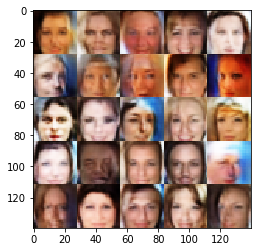

Epoch 1/1... Batch 5410... Discriminator Loss: 1.3472... Generator Loss: 0.8179
Epoch 1/1... Batch 5420... Discriminator Loss: 1.1393... Generator Loss: 0.9301
Epoch 1/1... Batch 5430... Discriminator Loss: 1.2289... Generator Loss: 1.0012
Epoch 1/1... Batch 5440... Discriminator Loss: 1.0657... Generator Loss: 1.1099
Epoch 1/1... Batch 5450... Discriminator Loss: 1.2822... Generator Loss: 0.8168
Epoch 1/1... Batch 5460... Discriminator Loss: 1.1893... Generator Loss: 0.8964
Epoch 1/1... Batch 5470... Discriminator Loss: 1.2138... Generator Loss: 0.8711
Epoch 1/1... Batch 5480... Discriminator Loss: 1.2160... Generator Loss: 0.9223
Epoch 1/1... Batch 5490... Discriminator Loss: 1.4325... Generator Loss: 0.7482
Epoch 1/1... Batch 5500... Discriminator Loss: 1.2237... Generator Loss: 0.8872


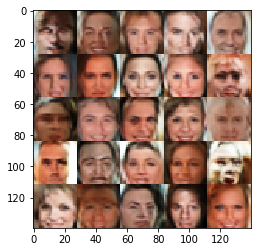

Epoch 1/1... Batch 5510... Discriminator Loss: 1.1624... Generator Loss: 0.9680
Epoch 1/1... Batch 5520... Discriminator Loss: 1.1723... Generator Loss: 0.8826
Epoch 1/1... Batch 5530... Discriminator Loss: 1.1322... Generator Loss: 0.9231
Epoch 1/1... Batch 5540... Discriminator Loss: 1.2049... Generator Loss: 0.8207
Epoch 1/1... Batch 5550... Discriminator Loss: 1.1987... Generator Loss: 0.8220
Epoch 1/1... Batch 5560... Discriminator Loss: 1.1159... Generator Loss: 0.9827
Epoch 1/1... Batch 5570... Discriminator Loss: 1.3469... Generator Loss: 0.7593
Epoch 1/1... Batch 5580... Discriminator Loss: 1.1915... Generator Loss: 1.0228
Epoch 1/1... Batch 5590... Discriminator Loss: 1.2511... Generator Loss: 0.8764
Epoch 1/1... Batch 5600... Discriminator Loss: 1.2054... Generator Loss: 0.9900


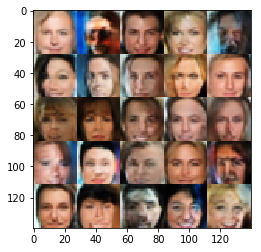

Epoch 1/1... Batch 5610... Discriminator Loss: 1.1777... Generator Loss: 0.9348
Epoch 1/1... Batch 5620... Discriminator Loss: 1.3052... Generator Loss: 1.2682
Epoch 1/1... Batch 5630... Discriminator Loss: 1.1507... Generator Loss: 1.0352
Epoch 1/1... Batch 5640... Discriminator Loss: 1.3631... Generator Loss: 0.8455
Epoch 1/1... Batch 5650... Discriminator Loss: 1.0675... Generator Loss: 0.9510
Epoch 1/1... Batch 5660... Discriminator Loss: 1.0908... Generator Loss: 0.9269
Epoch 1/1... Batch 5670... Discriminator Loss: 1.2837... Generator Loss: 0.6515
Epoch 1/1... Batch 5680... Discriminator Loss: 1.3324... Generator Loss: 0.7855
Epoch 1/1... Batch 5690... Discriminator Loss: 1.2415... Generator Loss: 0.8583
Epoch 1/1... Batch 5700... Discriminator Loss: 1.1639... Generator Loss: 0.7245


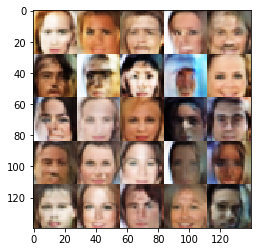

Epoch 1/1... Batch 5710... Discriminator Loss: 1.2220... Generator Loss: 0.8422
Epoch 1/1... Batch 5720... Discriminator Loss: 1.2310... Generator Loss: 0.8202
Epoch 1/1... Batch 5730... Discriminator Loss: 1.2181... Generator Loss: 0.9303
Epoch 1/1... Batch 5740... Discriminator Loss: 1.2757... Generator Loss: 0.8265
Epoch 1/1... Batch 5750... Discriminator Loss: 1.5863... Generator Loss: 1.0528
Epoch 1/1... Batch 5760... Discriminator Loss: 1.2700... Generator Loss: 0.8399
Epoch 1/1... Batch 5770... Discriminator Loss: 1.2832... Generator Loss: 0.8838
Epoch 1/1... Batch 5780... Discriminator Loss: 1.2194... Generator Loss: 0.9202
Epoch 1/1... Batch 5790... Discriminator Loss: 1.2918... Generator Loss: 0.8962
Epoch 1/1... Batch 5800... Discriminator Loss: 1.1984... Generator Loss: 0.8828


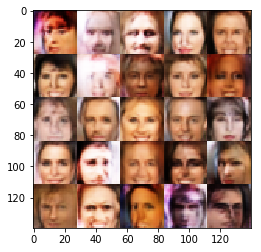

Epoch 1/1... Batch 5810... Discriminator Loss: 1.1774... Generator Loss: 0.9422
Epoch 1/1... Batch 5820... Discriminator Loss: 1.4986... Generator Loss: 0.6210
Epoch 1/1... Batch 5830... Discriminator Loss: 1.3067... Generator Loss: 0.8631
Epoch 1/1... Batch 5840... Discriminator Loss: 1.3078... Generator Loss: 0.8547
Epoch 1/1... Batch 5850... Discriminator Loss: 1.1475... Generator Loss: 0.8040


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 2e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.